In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [46]:
from proj1_helpers import *
from helpers import *
from costs import *
DATA_TRAIN_PATH = '../train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
stdx, mean_x, std_x=standardize(x)
x.shape

(250000, 30)

In [4]:
y

        

array([ 1., -1., -1., ...,  1., -1., -1.])

## Do your thing crazy machine learning thing here :) ...

Additional loss and helper functions

In [52]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return np.exp(t)/(1+np.exp(t))

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly=np.ones((x.shape[0],degree+1,x.shape[1]))
    for i in range(0,x.shape[0]):
        if i%100000==0: print("Building polynomial ", i)
        for d in range(1, degree+1):
            for j in range(0,x.shape[1]):
                poly[i][d][j]=np.power(x[i,j],d)
    return poly

def compute_rmse(y,tx,w):
    e=y-(tx @ w)
    return math.sqrt(1/y.shape[0]*(e @ e))


def calculate_loss_logistic_regression(y, tx, w):
    """compute the cost by negative log likelihood."""
    a=0
    for n in range(y.shape[0]):    
        a+=np.log(1+np.exp(tx[n].T @ w))-y[n]*tx[n].T @ w
    return a[0]

def build_tx(x):
    return np.c_[np.ones((x.shape[0], 1)), x]


def compute_loss_poly(train_y,train_tx,weight):
    w=weight.T   # We will process by degree not by dim
    y_predicted=np.zeros(train_y.shape[0])
    y_predicted_classed=np.ones(train_y.shape[0])
    for n in range(0,train_tx.shape[0]):
        if(n%50000==0):print("sample ",n)
        for degree in range(0,train_tx.shape[1]):
            y_predicted[n]+=w[degree] @ train_tx[n,degree]
        if(y_predicted[n]<0):y_predicted_classed[n]=-1
    e=train_y-y_predicted_classed
    return np.sqrt(1/train_y.shape[0]*(e @ e))
    

Gradients calculations

In [6]:
def compute_gradient_MSE(y,tx,w):
    """Compute the gradient."""
    e=y-(tx @ w)
    return -1/y.shape[0]*tx.T @ e

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient for batch data."""
    return compute_gradient_MSE(y,tx,w)

def compute_gradient_MAE(y,tx,w):
    sumX=0
    sumY=0
    for n in range(0,y.shape[0]):
        temp=y[n]-w[0]-w[1]*tx[n,1]
        if(temp>0):
            sumX=sumX-1
            sumY=sumY-tx[n,1]
        if(temp<0):
            sumX=sumX+1
            sumY=sumY+tx[n,1]
    return np.array([sumX/y.shape[0],sumY/y.shape[0]])

def calculate_gradient_logistic_regression(y, tx, w):
    """compute the gradient of loss."""
    return tx.T @ (sigmoid(tx @ w)-y)

def calculate_hessian(y, tx, w):
    """return the hessian of the loss function."""
    # calculate hessian: 
    S=np.zeros((y.shape[0],y.shape[0]))
    for i in range(0,y.shape[0]):
        S[i,i]=sigmoid(tx[i].T @ w)*(1-sigmoid(tx[i].T @ w))
    return tx.T @ S @ tx


def logistic_regression_newton(y, tx, w):
    """return the loss, gradient, and hessian."""
    # return loss, gradient, and hessian:
    return calculate_loss_logistic_regression(y,tx,w),calculate_gradient_logistic_regression(y,tx,w),calculate_hessian(y,tx,w)

def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient, and hessian."""
    # return loss, gradient, and hessian:
    loss,gradient,hessian=logistic_regression_newton(y,tx,w)
    loss+= lambda_*np.sum(w*w)
    gradient+=lambda_*np.sum(2*w)
    hessian+=lambda_*2*w.shape[0]
    return loss,gradient,hessian

Gradient descent (one step)

In [7]:
def learning_by_gradient_descent_logistic_regression(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    # compute the cost:
    #loss=calculate_loss_logistic_regression(y,tx,w)
    loss=compute_loss(y,tx,w)
    # compute the gradient:
    gradient=calculate_gradient_logistic_regression(y,tx,w)
    # update w:
    w=w-gamma*gradient
    return loss, w

def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step on Newton's method.
    return the loss and updated w.
    """
    # return loss, gradient and hessian:
    loss,gradient,hessian = logistic_regression_newton(y,tx,w)
    # update w:
    w=w-gamma * np.linalg.inv(hessian) @ gradient
    return loss, w

def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    # return loss, gradient and hessian:
    
    loss,gradient,hessian = penalized_logistic_regression(y,tx,w,lambda_)
    # update w:
    w=w-gamma * np.linalg.inv(hessian) @ gradient
    return loss, w


# DO GD linear regression with mse
def learning_by_GD_mse(y,tx,w,lambda_):
    return compute_loss(y,tx,w),w-lambda_*compute_gradient_MSE(y,tx,w)
# DO SGD linear regression with mse
def learning_by_SGD_mse(y,tx,w,lambda_):
    return compute_loss(y,tx,w),w-lambda_*compute_stoch_gradient(y,tx,w)

Normal equations

In [53]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w=np.linalg.inv(tx.T @ tx) @ tx.T @ y
    return compute_loss(y,tx,w),w

def ridge_regression(y, teta, lamb):
    """implement ridge regression.
    # For each dimension we have the weights
    ws=np.zeros((tx.shape[1],tx.shape[2]))
    
    for dim in range(0,tx.shape[2]):
        tx_per_dim=tx[:,dim,:] #one dimension
        ws[dim]=(np.linalg.solve((tx_per_dim.T @ tx_per_dim)+lamb*np.identity(tx_per_dim.shape[1]), tx_per_dim.T @ y))
    # We calculate the average
    return ws
    """
    
    teta_t=np.transpose(teta,(2,1,0))
    teta_good= np.transpose(teta,(2,0,1))
    to_add=(teta_t @ teta_good)
    
    to_inv=to_add+lamb*2*teta.shape[0]*np.identity(to_add.shape[1])
    
    #inv=np.linalg.inv(to_inv)
    #a=inv @ teta_t
    #b=a @ y
    b=teta_t @ y
    
    w=np.linalg.solve(to_inv,b) #/teta.shape[0]
    # is of form (Dimension X degree)
    return w
   


ML Functions

In [54]:
def gradient_descent_mse(y, tx, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss,w=learning_by_GD_mse(y,tx,w,gamma)
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
    return losses, ws

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iter, gamma):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    minibatchs = batch_iter(y, tx, batch_size, num_batches=np.int(y.shape[0]/batch_size))
    num_batches=np.int(y.shape[0]/batch_size)
    for n_iter in range(0,np.int(np.min([max_iter,num_batches]))):
        # compute gradient and loss
        minibatch=minibatchs.__next__()
        loss,w=learning_by_SGD_mse(minibatch[0],minibatch[1],w,gamma)
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
    return losses, ws

def logistic_regression_gradient_descent(y, x, max_iter, threshold,gamma):
    # init parameters
    losses = []
    #tx=build_tx(x)
    tx=x
    w = np.zeros((tx.shape[1]))
    ws=[]
    ws.append(w)
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        
        loss, w = learning_by_gradient_descent_logistic_regression(y, tx, w, gamma)
        # log info
        if iter % 1000 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        ws.append(w)
    return losses,ws

def logistic_regression_newton_method(y, x,max_iters,threshold,gamma):
    # init parameters
    losses = []
    #tx=build_tx(x)
    tx=x
    w = np.zeros((tx.shape[1]))
    ws=[]
    ws.append(w)
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, gamma)
        # log info
        if iter % 500 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        ws.append(w)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_newton_method")
    print("The loss={l}".format(l=calculate_loss(y, tx, w)))

def logistic_regression_penalized_gradient_descent(y, x,max_iters,threshold,gamma,lambda_):
    # init parameters
    losses = []
    #tx=build_tx(x)
    tx=x
    w = np.zeros((tx.shape[1]))
    ws=[]
    ws.append(w)
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 500 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        ws.append(w)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_penalized_gradient_descent")
    print("The loss={l}".format(l=calculate_loss(y, tx, w)))
    
    
def ridge_regression_ml_function(y,x_powered,lambda_):
    """ridge regression demo."""
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    #train_tx=build_poly(x,degree)
    train_tx=x_powered
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression with different lambda: TODO
    # ***************************************************
    weight = ridge_regression(y,train_tx,lambda_)
    loss=compute_loss_poly(y,train_tx,weight)
    return loss,weight
    
    


Cross-Validation

In [55]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x_poly, k_indices, k, lambda_):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    train_indices=k_indices[[i for i in range(len(k_indices)) if i != k]]
    train_tx,train_y=x_poly[np.ravel(train_indices)],y[np.ravel(train_indices)]
    test_tx,test_y=x_poly[k_indices[k]],y[k_indices[k]]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    weight = ridge_regression(train_y,train_tx,lambda_)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************
    loss_tr=compute_loss_poly(train_y,train_tx,weight)
    loss_te=compute_loss_poly(test_y,test_tx,weight)
    return loss_tr, loss_te,weight


### Testing different methods

Gradient descent mse

In [10]:
tx=build_tx(x)
initial_w=np.ones(tx.shape[1])
max_iters=500
gamma =0.0000000001
losses,ws=gradient_descent_mse(y, tx, initial_w, max_iters, gamma)


In [11]:
losses,ws=gradient_descent_mse(y, tx, ws[len(ws)-1], max_iters, gamma)

In [12]:
final_ws=ws[len(ws)-1]

In [13]:
losses

[14488053.728343694,
 14472114.754554447,
 14456194.016681407,
 14440291.493818505,
 14424407.16508366,
 14408541.009618729,
 14392693.00658947,
 14376863.13518556,
 14361051.37462051,
 14345257.704131668,
 14329482.102980206,
 14313724.550451051,
 14297985.025852902,
 14282263.508518172,
 14266559.977802962,
 14250874.413087063,
 14235206.793773899,
 14219557.099290501,
 14203925.309087509,
 14188311.402639106,
 14172715.359443014,
 14157137.159020472,
 14141576.780916186,
 14126034.204698326,
 14110509.409958487,
 14095002.376311658,
 14079513.083396202,
 14064041.510873837,
 14048587.638429591,
 14033151.445771797,
 14017732.912632039,
 14002332.018765138,
 13986948.743949156,
 13971583.067985311,
 13956234.970697992,
 13940904.431934722,
 13925591.43156613,
 13910295.949485919,
 13895017.965610858,
 13879757.459880732,
 13864514.412258331,
 13849288.802729417,
 13834080.611302707,
 13818889.818009825,
 13803716.402905311,
 13788560.346066553,
 13773421.627593799,
 13758300.2276101,

In [14]:
final_ws_GD_mse=ws[len(ws)-1]

Stochastic gradient descent mse

In [15]:
tx=build_tx(x)
initial_w=np.ones(tx.shape[1])
max_iters=500
gamma =0.0000000001
losses,ws=stochastic_gradient_descent(y, tx, initial_w, x.shape[0]/500, max_iters, gamma)
losses

C:\Users\HP Pace\Documents\GitHub\MLO-project1\scripts\helpers.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]


[23894990.032122701,
 25657670.379684858,
 24903585.608309388,
 25234665.7760607,
 24525918.98082418,
 27229180.305197425,
 23893760.627589416,
 24317171.430089876,
 25497332.62087208,
 26178514.923334233,
 25613957.040389273,
 25010799.759458899,
 25230163.600142904,
 26332749.419346664,
 24382442.741232626,
 26004544.561279036,
 26061209.528096363,
 24923551.815746401,
 25802124.765765898,
 25543702.273635849,
 24021057.447276451,
 23815810.734768759,
 23675600.698433485,
 25335564.124801941,
 24833837.876984511,
 24740637.745754316,
 24471431.066504985,
 24037185.460804623,
 25885466.069239751,
 23851224.447146829,
 24714946.832639635,
 24120284.354127016,
 24303575.60932152,
 24326974.839675538,
 24737329.557919759,
 24613234.881603666,
 25259961.700384002,
 24159630.617820475,
 24329055.960784219,
 23614106.493234016,
 24038981.479804873,
 23784971.585734118,
 24220097.822157312,
 23060491.250042986,
 25183330.911386531,
 22962251.439977624,
 24362607.715491761,
 24938742.71083584

In [16]:
losses,ws=stochastic_gradient_descent(y, tx, ws[len(ws)-1], x.shape[0]/500, max_iters, gamma)
losses

C:\Users\HP Pace\Documents\GitHub\MLO-project1\scripts\helpers.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]


[15470325.799969975,
 14192777.675960518,
 14148318.615577459,
 14644722.370317277,
 14177013.37818668,
 14224459.190269576,
 14761279.623222332,
 13611409.755071739,
 13502754.034042632,
 15237639.627170384,
 13926176.243662611,
 14542572.543201121,
 13957064.319552619,
 13880225.016062455,
 13910363.347619755,
 15186592.676472278,
 13881582.246449016,
 13947945.852802416,
 13872199.614315523,
 14367897.760229748,
 13856253.859321656,
 14761950.421071969,
 13919219.574412497,
 14729860.641825484,
 14210024.852006398,
 13778283.875981096,
 13691994.745634751,
 14535996.35092843,
 14215235.930889813,
 13843562.591168698,
 13400305.446432216,
 14485039.231476421,
 13329416.289762039,
 13717326.846429242,
 13362587.573835114,
 14562105.927615216,
 13783517.860072106,
 13829064.807183206,
 14541790.070842456,
 14504029.376524162,
 14654703.311700558,
 14011434.564725077,
 14673018.549876319,
 13116613.641577514,
 14223056.422506645,
 14371131.516222648,
 13771208.975631241,
 13876993.54501

In [17]:
final_SGD_gradient_ws = ws[len(ws)-1]

Least Squares

In [18]:
loss,final_LS_w=least_squares(y,tx)

In [19]:
loss

0.33944559851782757

In [20]:
final_LS_w

array([ -3.60668398e-01,   7.23061306e-05,  -7.14468236e-03,
        -6.24039951e-03,  -4.77145010e-04,  -3.08504353e-03,
         4.49444469e-04,  -2.38125455e-02,   3.42157704e-01,
        -1.09950486e-04,  -2.84186178e+00,  -2.16216038e-01,
         9.55448998e-02,   4.52028139e-02,   2.85042830e+00,
        -2.62729702e-04,  -9.95639898e-04,   2.85490239e+00,
        -3.54662999e-04,   8.49821857e-04,   3.69247838e-03,
         2.18113134e-04,  -5.00574872e-04,  -2.11522348e-01,
        -2.18882082e-04,   2.01549413e-04,   3.43135946e-04,
        -6.98404056e-05,  -6.58071046e-03,  -1.18306611e-02,
         2.84110926e+00])

Ridge Regression

In [24]:
degree=4
x_powered=build_poly(stdx,degree)
#split data !

Building polynomial  0
Building polynomial  100000
Building polynomial  200000


In [25]:
lambda_=0.01
np.zeros((30,5))
stdx
loss,w=ridge_regression_ml_function(y,x_powered,lambda_)
print(loss)


(250000, 5, 30)
y,train_tx,weight (250000,) (250000, 5, 30) (30, 5)
sample  0
sample  50000
sample  100000
sample  150000
sample  200000
1.17077751943


Cross validation with ridge regression

In [56]:
k_indices=build_k_indices(y,4,1)
loss_tr, loss_te,weight=cross_validation(y,x_powered,k_indices,0,10)

sample  0
sample  50000
sample  100000
sample  150000
sample  0
sample  50000


In [57]:
print(loss_tr, loss_te)

1.17236626814 1.16457030702


In [45]:
seed = 1
k_fold = 4
lambdas = np.logspace(-4, 2, 30)
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []
# ***************************************************
# INSERT YOUR CODE HERE
# cross validation: TODO
# *************************************************** 
for lambda_ in lambdas:
    print ("Lambda",lambda_,"/",len(lambdas))
    loss_tr=[]
    loss_te=[]
    for k in np.arange(k_fold):
        print ("k=",k)
        loss=np.zeros(2)
        loss[0],loss[1],weight=cross_validation(y,x_powered,k_indices,k,lambda_)
        loss_tr.append(loss[0])
        loss_te.append(loss[1])
    rmse_tr.append(np.mean(loss_tr))
    rmse_te.append(np.mean(loss_te))


Lambda 0.0001 / 30
k= 0
(187500, 5, 30) (187500,)
(187500, 5, 30)
y,train_tx,weight (187500,) (187500, 5, 30) (30, 5)
sample  0
sample  50000
sample  100000
sample  150000
y,train_tx,weight (62500,) (62500, 5, 30) (30, 5)
sample  0
sample  50000
k= 1
(187500, 5, 30) (187500,)
(187500, 5, 30)
y,train_tx,weight (187500,) (187500, 5, 30) (30, 5)
sample  0
sample  50000
sample  100000
sample  150000
y,train_tx,weight (62500,) (62500, 5, 30) (30, 5)
sample  0
sample  50000
k= 2
(187500, 5, 30) (187500,)
(187500, 5, 30)
y,train_tx,weight (187500,) (187500, 5, 30) (30, 5)
sample  0
sample  50000
sample  100000
sample  150000
y,train_tx,weight (62500,) (62500, 5, 30) (30, 5)
sample  0
sample  50000
k= 3
(187500, 5, 30) (187500,)
(187500, 5, 30)
y,train_tx,weight (187500,) (187500, 5, 30) (30, 5)
sample  0
sample  50000
sample  100000
sample  150000
y,train_tx,weight (62500,) (62500, 5, 30) (30, 5)
sample  0
sample  50000
Lambda 0.000161026202756 / 30
k= 0
(187500, 5, 30) (187500,)
(187500, 5, 

NameError: name 'cross_validation_visualization' is not defined

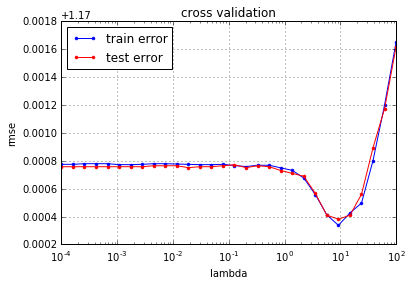

In [48]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)
# The graph shows us that lambda should be 10^1

Logistic regression

In [86]:
max_iters=2000
threshold=0.0000000000000001
gamma=0.000000001
sx, mean_x, std_x=standardize(x)

loss,ws=logistic_regression_gradient_descent(y,sx,max_iters,threshold,gamma)

Current iteration=0, the loss=0.5
Current iteration=1000, the loss=0.4178719682095945


In [87]:
sx.shape

(250000, 31)

In [92]:
loss

[0.5,
 0.49978034751905664,
 0.49956113907306915,
 0.49934237392289693,
 0.499124051330602,
 0.49890617055945025,
 0.49868873087390775,
 0.49847173153964064,
 0.49825517182351325,
 0.49803905099358597,
 0.49782336831911467,
 0.49760812307054875,
 0.49739331451953028,
 0.49717894193889123,
 0.49696500460265319,
 0.49675150178602551,
 0.49653843276540377,
 0.49632579681836797,
 0.49611359322368176,
 0.4959018212612904,
 0.49569048021231987,
 0.49547956935907439,
 0.49526908798503555,
 0.49505903537486151,
 0.49484941081438388,
 0.49464021359060778,
 0.49443144299170944,
 0.49422309830703515,
 0.49401517882709967,
 0.49380768384358481,
 0.49360061264933741,
 0.49339396453836892,
 0.4931877388058527,
 0.49298193474812368,
 0.49277655166267575,
 0.49257158884816138,
 0.49236704560438949,
 0.49216292123232402,
 0.4919592150340823,
 0.49175592631293402,
 0.49155305437329971,
 0.49135059852074875,
 0.49114855806199809,
 0.49094693230491154,
 0.49074572055849691,
 0.49054492213290513,
 0.490344

In [40]:

test_loss=compute_loss_poly(_,build_poly(tX_test,degree),w)

TypeError: build_poly() missing 1 required positional argument: 'degree'

Newton method

In [ ]:
test_loss

In [26]:
y

array([ 1., -1., -1., ...,  1., -1., -1.])

## Generate predictions and save ouput in csv format for submission:

In [38]:
DATA_TEST_PATH = '../test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)